In [1]:
%%html

<style>
.jp-MarkdownOutput {
    font-size: 2.5em !important;
}
.jp-MarkdownOutput table {
    font-size: 0.75em !important;
}
.jp-OutputArea-output pre {
    font-size: 2em !important;
}
.cm-content {
    font-size: 2em !important;
}
.page-id-xx, html {
    scrollbar-width: none; /* FF */
}
::-webkit-scrollbar {
    width: 0px; /* Chrome & Edge */
}
.jp-Notebook.jp-mod-commandMode .jp-Cell.jp-mod-selected {
    background: none;
}
</style>

# Adaptive basis functions

### The missing link between linear fitting and neural networks

<img src="img/sasquatch.jpg" style="width: 600px; max-width: 80%; margin: 30px auto 30px auto">

The purpose of this talk is to get a deeper understanding of why neural networks work.

I start with linear fitting because there's no mystery: we can see how they work.

You probably already know some of this material—most of you are practicing data analysts—but the point is the story arc, how we get from something familiar and obvious to something that tempts anthropomorphization.

### Linear fitting

You're given pairs of values, $x_i$ and $y_i$ (indexes $i \in [0, N)$ for $N$ pairs) that have an approximately linear relationship.

In [2]:
import numpy as np

<br>

In [3]:
# uniformly random x values
x = np.random.uniform(-5, 5, 100)

# linear (2 * x + 3) plus normal-distributed noise
y = (2 * x + 3) + np.random.normal(0, 3, 100)

In [4]:
import matplotlib.pyplot as plt

<br>

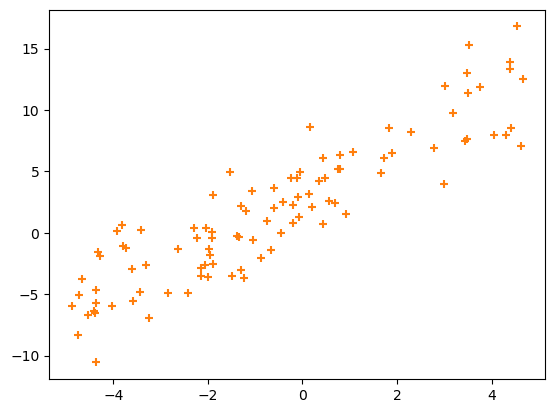

In [5]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker="+", color="tab:orange");

You can write an equation for an exact relationship:

$$ a \, x + b = y $$

and express the goodness of this model as a representation of the data by how close it gets to the actual points:

$$ \chi^2 = \sum_i \left[ (a \, x_i + b) - y_i \right]^2 $$

If $a$ and $b$ are chosen well, the line will go through the middle of the points.

<img src="img/equation-for-a-line.svg" style="width: 600px; max-width: 80%; margin: 30px auto 30px auto">

The best $a$ and $b$ are the values in which $\chi^2$ is minimized. Using calculus, there's an exact minimum that can be calculated like this:

In [6]:
sum1  = len(x)
sumx  = np.sum(x)
sumy  = np.sum(y)
sumxx = np.sum(x**2)
sumxy = np.sum(x * y)
delta = (sum1*sumxx) - (sumx*sumx)

a = ((sum1*sumxy) - (sumx*sumy))  / delta
b = ((sumxx*sumy) - (sumx*sumxy)) / delta
a, b

(np.float64(1.900881887948614), np.float64(2.9989178109243557))

<br>

Since the data were generated from

$$y_i = (a \, x + b) + \mbox{noise}$$

for $a = 2$ and $b = 3$, the best fit values should be _close_ to 2 and 3 (not exact because of the noise).

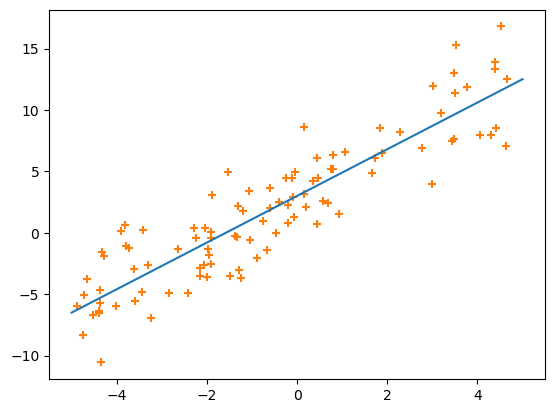

In [7]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker="+", color="tab:orange")

ax.plot([-5, 5], [a*-5 + b, a*5 + b], color="tab:blue");

Most problems have more than one independent variable ($x$), so we replace scalar $a$ and $x$ with vectors and use $\cdot$ for matrix multiplication:

$$\left(\begin{array}{c c}
a^1 & a^2 \\
\end{array}\right) \cdot \left(\begin{array}{c}
x^1 \\
x^2 \\
\end{array}\right) + b = y$$

<img src="img/equation-for-a-plane.svg" style="width: 600px; max-width: 80%; margin: 30px auto 30px auto">

Most problems have more than one given variable, so we replace scalar $x$ and $a$ with vectors $\vec{x}$ and $\vec{a}$ and use $\cdot$ for matrix multiplication:

$$\left(\begin{array}{c c c c}
a^1 & a^2 & \cdots & a^n \\
\end{array}\right) \cdot \left(\begin{array}{c}
x^1 \\
x^2 \\
\vdots \\
x^n
\end{array}\right) + b = y$$

(No picture. 😞)

Many problems also have more than one given variable, so we replace $y$ and $b$ with vectors $\vec{y}$ and $\vec{b}$, and now $\hat{a}$ needs to be a full matrix.

$$\left(\begin{array}{c c c c}
a^{1,1} & a^{1,2} & \cdots & a^{1,n} \\
a^{2,1} & a^{2,2} & \cdots & a^{2,n} \\
\vdots & \vdots & & \vdots \\
a^{m,1} & a^{m,2} & \cdots & a^{m,n} \\
\end{array}\right) \cdot \left(\begin{array}{c}
x^1 \\
x^2 \\
\vdots \\
x^n
\end{array}\right) + \left(\begin{array}{c}
b^1 \\
b^2 \\
\vdots \\
b^m
\end{array}\right) = \left(\begin{array}{c}
y^1 \\
y^2 \\
\vdots \\
y^m
\end{array}\right)$$

Side-note: we can reduce this to just one matrix multiplication by adding a fake dimension to $\vec{x}$ whose value is always $1$ and move the $\vec{b}$ into a column of $\hat{a}$.

$$\left(\begin{array}{c c c c c}
a^{1,1} & a^{1,2} & \cdots & a^{1,n} & b^1 \\
a^{2,1} & a^{2,2} & \cdots & a^{2,n} & b^2 \\
\vdots & \vdots & & \vdots & \vdots \\
a^{m,1} & a^{m,2} & \cdots & a^{m,n} & b^m \\
\end{array}\right) \cdot \left(\begin{array}{c}
x^1 \\
x^2 \\
\vdots \\
x^n \\
1
\end{array}\right) = \left(\begin{array}{c}
y^1 \\
y^2 \\
\vdots \\
y^m
\end{array}\right)$$

Goodness of fit can still be expressed by a $\chi^2$,

$$\chi^2 = \sum_i || (\hat{a} \cdot \vec{x}_i + \vec{b}) - \vec{y}_i ||^2$$

and the solution is still exact, though [the derivation](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) involves more intense linear algebra.

$$\hat{A} = (\hat{X}^T \, \hat{X})^{-1} \, \hat{X}^T \, \hat{Y}$$

where
* $\hat{X}$ is the matrix of $\vec{x}_i$ features (with the "fake" dimension)
* $\hat{Y}$ is a matrix of $\vec{y}_i$ predictions.

This is the form in which fitting libraries expect the problem to be cast.

In [8]:
from sklearn.linear_model import LinearRegression

<br>

In [9]:
# Scikit-Learn wants X to be an array of vectors, even if they're 1-dimensional
X = x[:, np.newaxis]
Y = y

best_fit = LinearRegression().fit(X, y)

(a,) = best_fit.coef_
b = best_fit.intercept_

a, b

(np.float64(1.9008818879486142), np.float64(2.9989178109243557))

Or with more dimensions:

In [10]:
# uniformly random 2-D vectors
X = np.random.uniform(-5, 5, (100000, 2))

# true linear relationship (2-D → 3-D)
a_true = np.array([[1.1, 2.2],
                   [3.3, 4.4],
                   [5.5, 6.6]])
b_true = np.array([7.7, 8.8, 9.9])

# linear (a_true · b_true) for each x ∈ X plus noise
Y = (X @ a_true.T + b_true) + np.random.normal(0, 1, (100000, 3))

<br>

In [11]:
best_fit = LinearRegression().fit(X, Y)

<br>

In [12]:
best_fit.coef_

array([[1.10106238, 2.20022568],
       [3.29982585, 4.40106503],
       [5.49918706, 6.60064256]])

<br>

In [13]:
best_fit.intercept_

array([7.69571711, 8.80429477, 9.90312351])

### Beyond linear fitting

Many problems have relationships between given variables ($x$) and predicted variables ($y$) that are not linear, so we'll need to generalize.

How we generalize depends critically on whether we know the _shape_ of the true relationship.

**Example:** an object tossed through the air has an altitude versus time curve, $y(t)$, like this:

$$y(t) = y(t; \, \underbrace{y_0, \, t_0, \, \mu, \, t_f}_{\mbox{parameters}}) = y_0 - \frac{1}{\mu} \log \left( \cosh \frac{t - t_0}{t_f} \right)$$

where $y_0$ and $t_0$ are the starting position and time, and $\mu$ and $t_f$ are related to the air resistance.

In [14]:
def y_true(t):
    y0, t0, mu, tf = 60, 3, 0.05, 2
    return y0 - (1/mu)*np.log(np.cosh((t - t0)/tf))

def measurement_error(n):
    return np.random.normal(0, 1, n)

t = np.linspace(0, 10, 50)
y = y_true(t) + measurement_error(50)

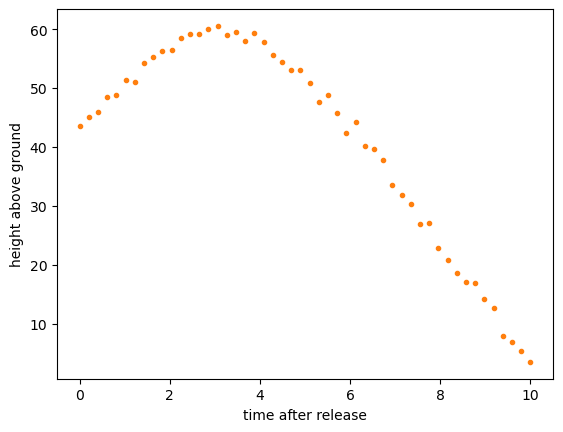

In [15]:
fig, ax = plt.subplots()

ax.scatter(t, y, marker=".", color="tab:orange")

ax.set_xlabel("time after release")
ax.set_ylabel("height above ground");

A linear fit would be a disaster:

In [16]:
best_fit = LinearRegression().fit(t[:, np.newaxis], y)
(linear_slope,), linear_intercept = best_fit.coef_, best_fit.intercept_

<br>

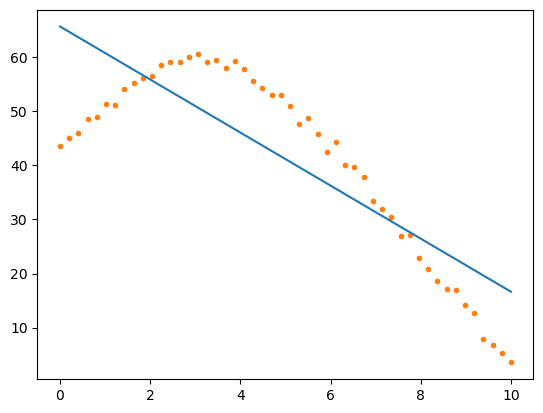

In [17]:
fig, ax = plt.subplots()

ax.plot([0, 10], [linear_slope * 0 + linear_intercept,
                  linear_slope * 10 + linear_intercept])
ax.scatter(t, y, marker=".", color="tab:orange");

Knowing the shape, $y(t; \, y_0, \, t_0, \, \mu, \, t_f)$, we can define a goodness of fit as before:

$$\chi^2 = \sum_i \left[f(x) - y\right]^2$$

and find the parameters $y_0$, $t_0$, $\mu$, $t_f$ that minimize $\chi^2$.

<br>

However, this would be a different calculus problem for every shape, and may be impossible for some.

Particle physicist's solution: write a general numerical minimizer and use it on all problems everywhere (🔨). It's called [Minuit](https://doi.org/10.1016/0010-4655(75)90039-9) and it was introduced in 1975.

<img src="img/minuit-turned-50.png" style="width: 1200px; max-width: 100%; margin: 50px auto 30px auto">

In [18]:
from iminuit import Minuit

In [19]:
def y_of_t_parameterized(t, y0, t0, mu, tf):
    return y0 - (1/mu)*np.log(np.cosh((t - t0)/tf))

def chi2(y0, t0, mu, tf):
    return np.sum((y_of_t_parameterized(t, y0, t0, mu, tf) - y)**2)

minimizer = Minuit(chi2, y0=100, t0=0, mu=0.1, tf=3)   # ← initial guess of parameters
minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 41.46                      │              Nfcn = 756              │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y0   │   59.66   │   0.29    │            │            │         │         │       │
│ 1 │ t0   │   3.036   │   0.026   │            │            │         │         │       │
│ 2 │ mu   │   0.043   │   0.004   │            │            │         │         │       │
│ 3 │ tf   │   2.23    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        y0        t0        mu        tf │
├────┼─────────────────────────────────────────┤
│ y0 │    0.0869    0.9e-3  0.711e-3    -0.031 │
│ t0 │    0.9e-3   0.00067        -0   -0.3e-3 │
│ mu │  0.711e-3        -0  1.38e-05 -0.552e-3 │
│ tf │    -0.031   -0.3e-3 -0.552e-3    0.0223 │
└────┴─────────────────────────────────────────┘

<br>

In [20]:
{p.name: p.value for p in minimizer.params}

{'y0': 59.664457644858665,
 't0': 3.0363185375523276,
 'mu': 0.04284472945934684,
 'tf': 2.230551029049781}

In [21]:
y_of_t = y_of_t_parameterized(t, **{p.name: p.value for p in minimizer.params})

<br>

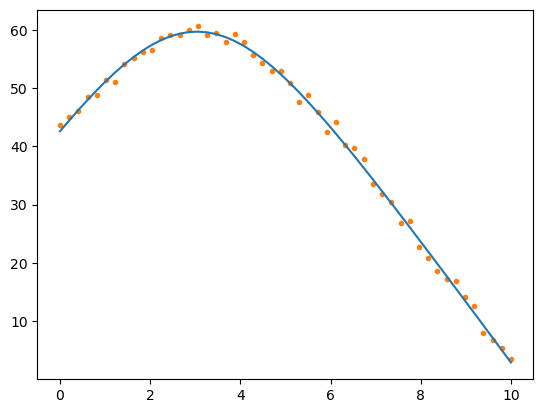

In [22]:
fig, ax = plt.subplots()

ax.plot(t, y_of_t)
ax.scatter(t, y, marker=".", color="tab:orange");

Great! But what if we assumed the formula for an object tossed _without_ air resistance?

$$y(t) = y_0 - \frac{1}{2}g(t - t_0)^2$$

In [23]:
def y_of_t_wrong_shape(t, y0, t0, g):
    return y0 - (1/2)*g*(t - t0)**2

def chi2_wrong_shape(y0, t0, g):
    return np.sum((y_of_t_wrong_shape(t, y0, t0, g) - y)**2)

minimizer_wrong_shape = Minuit(chi2_wrong_shape, y0=100, t0=0, g=5)
minimizer_wrong_shape.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 345                        │              Nfcn = 116              │
│ EDM = 3.53e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y0   │   56.47   │   0.20    │            │            │         │         │       │
│ 1 │ t0   │   2.91    │   0.04    │            │            │         │         │       │
│ 2 │ g    │   2.35    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────┐
│    │      y0      t0       g │
├────┼─────────────────────────┤
│ y0 │  0.0381  0.0002  0.0028 │
│ t0 │  0.0002  0.0015  0.0012 │
│  g │  0.0028  0.0012 0.00132 │
└────┴─────────────────────────┘

In [24]:
y_of_t = y_of_t_wrong_shape(t, **{p.name: p.value for p in minimizer_wrong_shape.params})

<br>

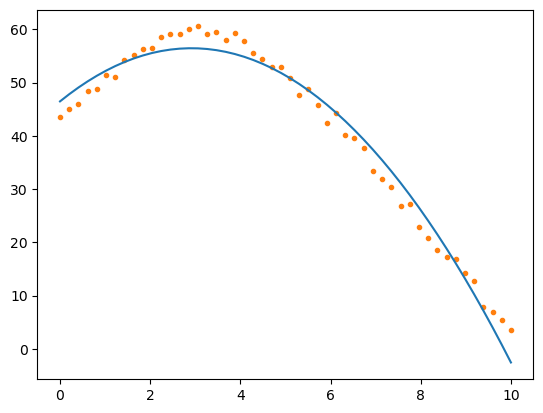

In [25]:
fig, ax = plt.subplots()

ax.plot(t, y_of_t)
ax.scatter(t, y, marker=".", color="tab:orange");

Or even just a bad initial guess of the parameter values?

In [26]:
minimizer_bad_guess = Minuit(chi2, y0=100, t0=100, mu=100, tf=100)   # ← initial guess
minimizer_bad_guess.migrad()

y_of_t = y_of_t_parameterized(t, **{p.name: p.value for p in minimizer_bad_guess.params})

<br>

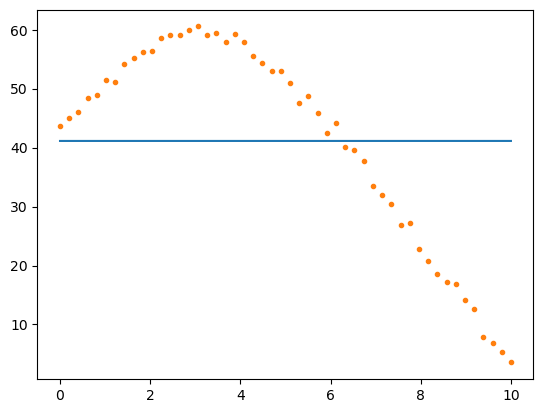

In [27]:
fig, ax = plt.subplots()

ax.plot(t, y_of_t)
ax.scatter(t, y, marker=".", color="tab:orange");

The Minuit approach is popular in physics because the goal of physics is to find the underlying functional shape and its parameters.

But any problems involving complex systems, especially people, can't be derived from first principles.

So we need a way to fit functions without knowing what their shapes are.

### Universal approximators

**Classical:**
* Taylor and orthogonal polynomials (Legendre, Jacobi, Laguerre, Hermite, Chebyshev...)
* Fourier series

**Neural networks in disguise:**
* Adaptive basis functions

In many contexts, polynomial series are the "go to" universal approximators:

$$ f(x) \approx f^N(x) = \sum_n^N a_n \, x^n $$

for suitably chosen $a_n$ ($n \in [0, N)$). Higher cut-offs $N$ yield better approximatoins.

<img src="img/Logarithm_GIF.gif" style="max-width: 80%; margin: 0 auto 0 auto">

<span style="font-size: 0.5em;">Credit: <a href="https://commons.wikimedia.org/w/index.php?curid=27892918">IkamusumeFan - Own work, CC BY-SA 3.0</a></span>

On $-1 < x < 1$ with uniform weight, there's a series of Legendre polynomials $P_n(x)$ that are orthogonal to one another:

$$ \int_{-1}^1 P_n(x) \, P_m(x) \, dx = 0 \mbox{\hspace{1 cm} if $n \ne m$} $$

$P_0(x) = 1$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$P_1(x) = x$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$P_2(x) = \frac{1}{2}(3x^2 - 1)$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$P_3(x) = \frac{1}{2}(5x^3 - 3x)$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...

<br>

For a function

$$ f^N(x) = \sum_n^N a_n \, P_n(x) \mbox{\hspace{1 cm} that approximates \hspace{1 cm}} y_i \approx f^N(x_i), $$

each $a_n$ can be computed independently of all other $a_m$ by integration.

This series of polynomials is an _orthogonal basis_ for the space of smooth functions on $-1 < x < 1$: you can make any shape by adding them with the right combination of coefficients.

But since orthogonal polynomial series are all linear combinations of simple powers,

$p_0(x) = 1$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$p_1(x) = x$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$p_2(x) = x^2$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$p_3(x) = x^3$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Taylor series)

we can be lazy and just fit a curve to $p_n(x)$ (the best-fit coefficients will be correlated).

<br>

In [28]:
X = np.vstack([[np.ones_like(t)], [t], [t**2], [t**3]]).T
best_fit = LinearRegression(fit_intercept=False).fit(X, y)

y_of_t = np.sum(X * best_fit.coef_[np.newaxis, :], axis=1)

<br>

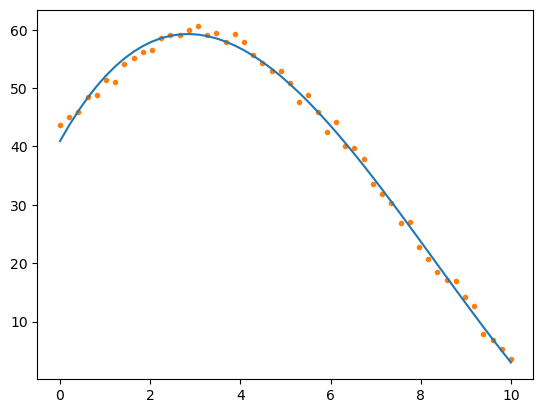

In [29]:
fig, ax = plt.subplots()

ax.plot(t, y_of_t)
ax.scatter(t, y, marker=".", color="tab:orange");

Let's do this with a trickier problem:

$$y = \left\{\begin{array}{l l}
\sin(22 x) & \mbox{if } |x - 0.43| < 0.15 \\
-1 + 3.5 x - 2 x^2 & \mbox{otherwise} \\
\end{array}\right.$$

In [30]:
def truth(x):
    return np.where(abs(x - 0.43) < 0.15, np.sin(22*x), -1 + 3.5*x - 2*x**2)

x = np.random.uniform(0, 1, 1000)
y = truth(x) + np.random.normal(0, 0.03, 1000)

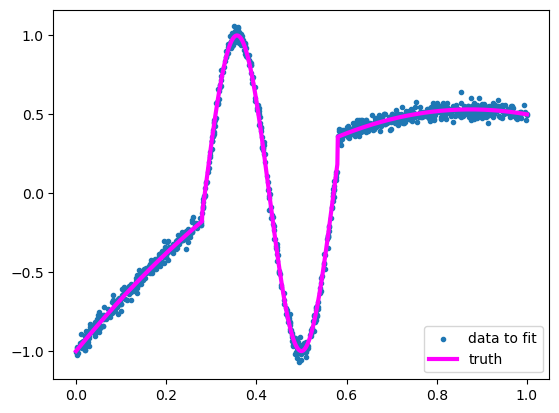

In [31]:
fig, ax = plt.subplots()

curve_x = np.linspace(0, 1, 1000)
curve_y = truth(curve_x)

ax.scatter(x, y, marker=".", label="data to fit")
ax.plot(curve_x, curve_y, color="magenta", linewidth=3, label="truth")

ax.legend(loc="lower right");

In [32]:
NUMBER_OF_POLYNOMIAL_TERMS = 15

coefficients = np.polyfit(x, y, NUMBER_OF_POLYNOMIAL_TERMS - 1)[::-1]

model_x = np.linspace(0, 1, 1000)
model_y = sum(c * model_x**i for i, c in enumerate(coefficients))

<br>

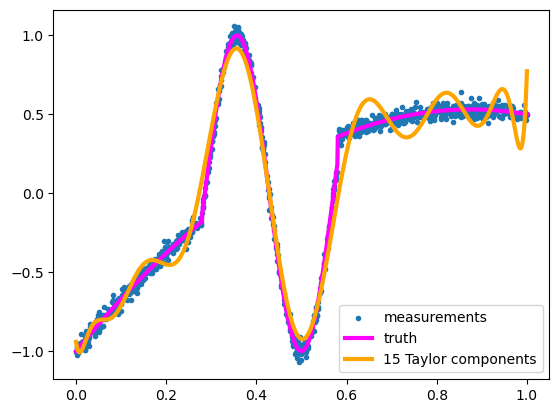

In [33]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(curve_x, curve_y, color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{len(coefficients)} Taylor components"], loc="lower right");

Fourier series are another classical universal approximator, built from powers of $\sin(x)$ and $\cos(x)$ over some period $P$, rather than polynomials of $x$.

$$\begin{array}{c}
f(x) = a_0 + a_1 \cos\left(2\pi\frac{1}{P}x\right) + b_1 \sin\left(2\pi\frac{1}{P}x\right) + \\ \hspace{7 cm} a_2 \cos\left(2\pi\frac{2}{P}x\right) + b_2 \sin\left(2\pi\frac{2}{P}x\right) + \ldots \end{array}$$

They're also orthogonal, so each coefficient can be determined independently of each other.

$$
\begin{align}
a_0 &&=&& \frac{1}{P} \int_P f(x) \, dx \\
a_n &&=&& \frac{2}{P} \int_P f(x) \cos\left(2\pi\frac{n}{P}x\right) \, dx \\
b_n &&=&& \frac{2}{P} \int_P f(x) \sin\left(2\pi\frac{n}{P}x\right) \, dx \\
\end{align}
$$

In [34]:
NUMBER_OF_COS_TERMS = 7
NUMBER_OF_SIN_TERMS = 7

sort_index = np.argsort(x)
x_sorted = x[sort_index]
y_sorted = y[sort_index]

constant_term = np.trapezoid(y_sorted, x_sorted)
cos_terms = [2*np.trapezoid(y_sorted * np.cos(2*np.pi * (i + 1) * x_sorted), x_sorted)
             for i in range(NUMBER_OF_COS_TERMS)]
sin_terms = [2*np.trapezoid(y_sorted * np.sin(2*np.pi * (i + 1) * x_sorted), x_sorted)
             for i in range(NUMBER_OF_SIN_TERMS)]

model_x = np.linspace(0, 1, 1000)
model_y = (
    constant_term +
    sum(coefficient * np.cos(2*np.pi * (i + 1) * model_x)
        for i, coefficient in enumerate(cos_terms)) +
    sum(coefficient * np.sin(2*np.pi * (i + 1) * model_x)
        for i, coefficient in enumerate(sin_terms))
)

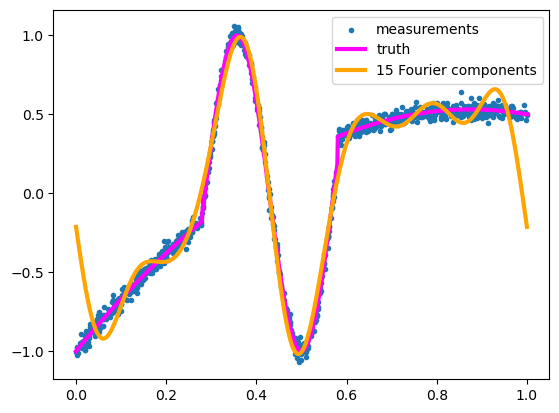

In [35]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(curve_x, curve_y, color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{1 + len(cos_terms) + len(sin_terms)} Fourier components"]);

What orthogonal polygons and Fourier series have in common: they all approximate a function with a _fixed set_ of basis functions $\phi_n$ for $n \in [0, N_{\mbox{functions}})$.

$$f(x) = \sum_n^{N_{\mbox{functions}}} c_n \, \psi_n(x)$$

<br>

Suppose, instead, that we had a set of functions that could also _change shape:_

$$f(x) = \sum_n^{N_{\mbox{functions}}} c_n \, \psi(x; \, \underbrace{\alpha_n, \, \beta_n}_{\mbox{parameters}})$$

<br>

Rather than having to wait for enough terms to get one with a wiggle in the right spot, the fitter would be able to put one of these functions in the right spot.

For example, suppose that our set of functions $\phi_n$ were sigmoids with adjustable center $\alpha$ and width $\beta$.

$$\psi(x; \alpha, \beta) = \frac{1}{1 + \exp\left((x - \alpha)/\beta\right)}$$

In [36]:
def sigmoid_component(x, center, width):
    with np.errstate(over="ignore", divide="ignore"):  # ignore NumPy warnings
        return 1 / (1 + np.exp((x - center) / width))

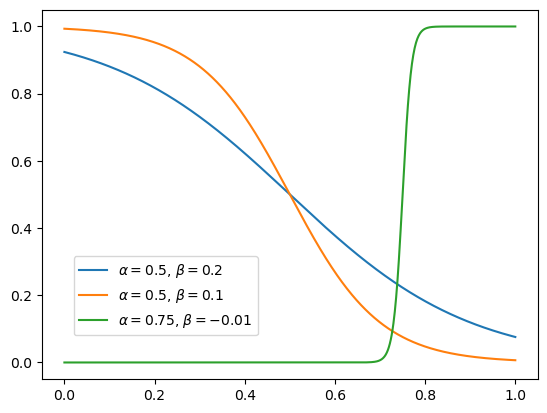

In [37]:
fig, ax = plt.subplots()

sample_x = np.linspace(0, 1, 1000)
ax.plot(model_x, sigmoid_component(sample_x, 0.5, 0.2), label=r"$\alpha = 0.5$, $\beta = 0.2$")
ax.plot(model_x, sigmoid_component(sample_x, 0.5, 0.1), label=r"$\alpha = 0.5$, $\beta = 0.1$")
ax.plot(model_x, sigmoid_component(sample_x, 0.75, -0.01), label=r"$\alpha = 0.75$, $\beta = -0.01$")

ax.legend(loc="lower left", bbox_to_anchor=(0.05, 0.1));

These adaptive basis functions are not orthogonal, so the best fit can't be solved by an analytic formula or an integration. Instead, we have to do a generic search.

In [38]:
NUMBER_OF_SIGMOIDS = 5

def sigmoid_sum(x, parameters):
    out = np.zeros_like(x)
    for coefficient, center, width in parameters.reshape(-1, 3):
        out += coefficient * sigmoid_component(x, center, width)
    return out

def least_squares(parameters):
    return np.sum((sigmoid_sum(x, parameters) - y)**2)

best_minimizer = None
for iteration in range(15):  # best of 15 optimizations; this is a difficult fit
    initial_parameters = np.zeros(5 * 3)
    initial_parameters[0::3] = np.random.normal(0, 1, NUMBER_OF_SIGMOIDS)    # coefficient terms
    initial_parameters[1::3] = np.random.uniform(0, 1, NUMBER_OF_SIGMOIDS)   # center parameters (alpha)
    initial_parameters[2::3] = np.random.normal(0, 0.1, NUMBER_OF_SIGMOIDS)  # width parameters (beta)

    minimizer = Minuit(least_squares, initial_parameters)
    minimizer.migrad()

    if best_minimizer is None or minimizer.fval < best_minimizer.fval:
        best_minimizer = minimizer

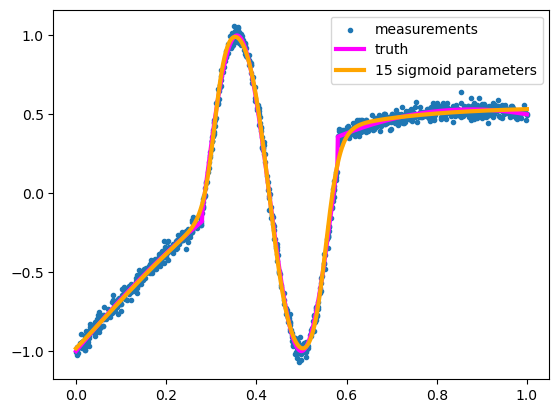

In [39]:
fig, ax = plt.subplots()

model_x = np.linspace(0, 1, 1000)
model_y_adaptive = sigmoid_sum(model_x, np.array(best_minimizer.values))

ax.scatter(x, y, marker=".")
ax.plot(curve_x, curve_y, color="magenta", linewidth=3)
ax.plot(model_x, model_y_adaptive, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{len(minimizer.parameters)} sigmoid parameters"]);

Not only is it a better fit with 15 parameters, but it generalizes better.

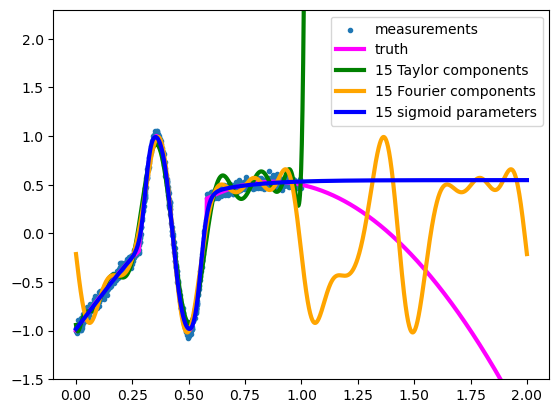

In [40]:
fig, ax = plt.subplots()

curve_x = model_x = np.linspace(0, 2, 2000)
curve_y = truth(curve_x)
model_y_polynomial = sum(c * model_x**i for i, c in enumerate(coefficients))
model_y_fourier = (
    constant_term +
    sum(coefficient * np.cos(2*np.pi * (i + 1) * model_x)
        for i, coefficient in enumerate(cos_terms)) +
    sum(coefficient * np.sin(2*np.pi * (i + 1) * model_x)
        for i, coefficient in enumerate(sin_terms))
)
model_y_adaptive = sigmoid_sum(model_x, np.array(best_minimizer.values))

ax.scatter(x, y, marker=".")
ax.plot(curve_x, curve_y, color="magenta", linewidth=3)
ax.plot(model_x, model_y_polynomial, color="green", linewidth=3)
ax.plot(model_x, model_y_fourier, color="orange", linewidth=3)
ax.plot(model_x, model_y_adaptive, color="blue", linewidth=3)

ax.legend(["measurements", "truth",
           f"{len(coefficients)} Taylor components",
           f"{1 + len(cos_terms) + len(sin_terms)} Fourier components",
           f"{len(minimizer.parameters)} sigmoid parameters"])
ax.set_ylim(-1.5, 2.3);

That is, lacking any information, it limits to a constant, rather than shooting into space as a high-order polynomial or repeating the pattern as a cyclic function.

By varying the scale ($c_n$), center ($\alpha_n$), and width ($\beta_n$) of each sigmoid, we can build any sandcastle we want. They all level off to zero outside the domain.

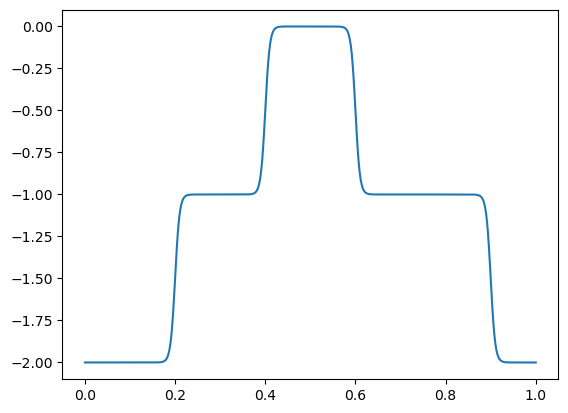

In [41]:
fig, ax = plt.subplots()

model_x = np.linspace(0, 1, 1000)

wide_plateau_left = sigmoid_component(model_x, 0.2, 0.005)
wide_plateau_right = sigmoid_component(model_x, 0.9, -0.005)

narrow_peak_left = sigmoid_component(model_x, 0.4, 0.005)
narrow_peak_right = sigmoid_component(model_x, 0.6, -0.005)

ax.plot(model_x, -wide_plateau_left - wide_plateau_right - narrow_peak_left - narrow_peak_right);

### What does this have to do with neural networks?